In [5]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [ ]:
#Preparing data to answer the following questions:
#What are the trends in types of Hate Crimes throughout 2019?
#How does demographic makeup of a state affect types of Hate Crimes committed?
#How does demographic makeup of a state affect # of Hate Crimes committed?

In [6]:
#Called in Hate Crime dataset
HateCrime2019 = pd.read_csv("Data Files/Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_Federal_and_Agency_2019.csv")
HateCrime2019.head()

,State,Agency Type,Agency,Race/\nEthnicity/\nAncestry,Religion,Sexual\norientation,Disability,Gender,Gender\nidentity,1st\nquarter,2nd\nquarter,3rd\nquarter,4th\nquarter,Population
0,Alaska,Cities,Anchorage,4.0,0,2.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,287731.0
1,Alaska,Cities,Fairbanks,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31493.0
2,Alaska,Cities,Kotzebue,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3272.0
3,Alaska,Cities,North Pole,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,2111.0
4,Alaska,Cities,Soldotna,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4756.0


In [7]:
#Data Wrangling
#Cleaned up headers (removed spaces and symbols, and simplified/clarified).
HateCrime2019.rename(columns={'Agency Type' : 'AgencyType', 'Race/\nEthnicity/\nAncestry' : 'TargetRace', 
                              'Sexual\norientation' : 'TargetSexOrientation', 'Gender\nidentity' : 'TargetGenderID', 
                              '1st\nquarter' : '1stQtr', '2nd\nquarter' : '2ndQtr', '3rd\nquarter' : '3rdQtr', 
                              '4th\nquarter' : '4thQtr', 'Religion' : 'TargetReligion', 'Disability' : 'TargetDisability',
                             'Gender' : 'TargetGender'}, inplace=True)

In [8]:
#Viewed headers to confirm code worked.
HateCrime2019.head()

,State,AgencyType,Agency,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,1stQtr,2ndQtr,3rdQtr,4thQtr,Population
0,Alaska,Cities,Anchorage,4.0,0,2.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,287731.0
1,Alaska,Cities,Fairbanks,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31493.0
2,Alaska,Cities,Kotzebue,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3272.0
3,Alaska,Cities,North Pole,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,2111.0
4,Alaska,Cities,Soldotna,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4756.0


In [9]:
#Since questions are focused on the state level, breakdown according to local agency (city data) is not needed,
#meaning "AgencyType" and "Agency" columns are unnecessary.
#Questions focus on # and type of Hate Crimes and the interaction with state demographics, 
#so "1stQtr","2ndQtr","3rdQtr","4thQtr" columns are unnecessary.
HateCrime2019A = HateCrime2019[['State', 'TargetRace', 'TargetReligion', 'TargetSexOrientation', 'TargetDisability', 
                                'TargetGender', 'TargetGenderID', 'Population']]

In [10]:
HateCrime2019A.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population
0,Alaska,4.0,0,2.0,0.0,0.0,0.0,287731.0
1,Alaska,1.0,0,0.0,0.0,0.0,0.0,31493.0
2,Alaska,1.0,0,0.0,0.0,0.0,0.0,3272.0
3,Alaska,1.0,0,0.0,0.0,0.0,0.0,2111.0
4,Alaska,0.0,0,2.0,0.0,0.0,0.0,4756.0


In [11]:
#Need to see if there are any unique values in the State column that need to be dealt with.
HateCrime2019A["State"].unique()
#This shows "Federal" and "NaN" as values in the "State" column

array(['Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', nan,
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Federal'], dtype=object)

In [12]:
#Since questions are focused on the state level only, cannot use Federal data.
#Removed any rows from the "HateCrime2019" dataset where the State value is "Federal".
HateCrime2019B = HateCrime2019A[HateCrime2019A.State != 'Federal']

In [13]:
#Also appear to have NaN values in the State column - can't use those rows.
#Dropped rows missing "State" data
HateCrime2019NoNA = HateCrime2019B[HateCrime2019B['State'].notna()]

In [14]:
#Looked again for unique values in State column to confirm code worked.
HateCrime2019NoNA["State"].unique()

array(['Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [15]:
#Viewed tail to see how many records in dataset
HateCrime2019NoNA.tail()
#Total of 2125 records/rows

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population
2120,Wyoming,1.0,0,0.0,0.0,0.0,0.0,9865.0
2121,Wyoming,1.0,0,0.0,0.0,0.0,0.0,11624.0
2122,Wyoming,0.0,0,1.0,0.0,0.0,0.0,32669.0
2123,Wyoming,1.0,0,0.0,0.0,0.0,0.0,17895.0
2124,Wyoming,1.0,0,0.0,0.0,0.0,0.0,13963.0


In [16]:
#Want to see if there are any other nulls in the HateCrime2019 dataset.
HateCrime2019NoNA[HateCrime2019NoNA.isnull().any(1)]

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population
26,Arkansas,1.0,0,0.0,0.0,0.0,0.0,NaN
27,Arkansas,0.0,0,1.0,0.0,0.0,0.0,NaN
200,California,10.0,1,3.0,0.0,1.0,0.0,NaN
201,California,2.0,2,0.0,0.0,0.0,0.0,NaN
202,California,1.0,0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
2115,Wisconsin,2.0,0,1.0,0.0,0.0,0.0,NaN
2116,Wisconsin,1.0,0,0.0,0.0,0.0,0.0,NaN
2117,Wisconsin,1.0,0,0.0,0.0,0.0,0.0,NaN
2118,Wisconsin,1.0,0,0.0,0.0,0.0,0.0,NaN


In [17]:
#There appear to be a fair number of NaN values, especially in "Population" column. How many nulls still in dataset?
HateCrime2019NoNA.isnull().sum().sum()

523

In [18]:
#523 out of 2125 records is approximately a quarter of the data, so I need to either source the data from elsewhere
#or transform the data here somehow. Since I've already decided to build a demographics dataset and the source includes
#state population data, I will include that in the dataset build and drop this population data.
del HateCrime2019NoNA['Population']
HateCrime2019NoNA.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID
0,Alaska,4.0,0,2.0,0.0,0.0,0.0
1,Alaska,1.0,0,0.0,0.0,0.0,0.0
2,Alaska,1.0,0,0.0,0.0,0.0,0.0
3,Alaska,1.0,0,0.0,0.0,0.0,0.0
4,Alaska,0.0,0,2.0,0.0,0.0,0.0


In [20]:
#Viewed any nulls to confirm code worked.
HateCrime2019NoNA[HateCrime2019NoNA.isnull().any(1)]

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID
1232,New Jersey,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#This row contains no useful data, so we need to drop it. Also a good time to give this cleaned up set a name.
HateCrime2019NoNA = HateCrime2019NoNA.dropna(how='any',axis=0)

In [22]:
#Now check to see if code worked.
HateCrime2019NoNA[HateCrime2019NoNA.isnull().any(1)]

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID


In [23]:
#Just to be sure, check a different way to make sure there are no other nulls.
HateCrime2019NoNA.isnull().sum().sum()

0

In [24]:
HateCrime2019NoNA.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID
0,Alaska,4.0,0,2.0,0.0,0.0,0.0
1,Alaska,1.0,0,0.0,0.0,0.0,0.0
2,Alaska,1.0,0,0.0,0.0,0.0,0.0
3,Alaska,1.0,0,0.0,0.0,0.0,0.0
4,Alaska,0.0,0,2.0,0.0,0.0,0.0


In [25]:
HateCrime2019NoNA.tail()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID
2120,Wyoming,1.0,0,0.0,0.0,0.0,0.0
2121,Wyoming,1.0,0,0.0,0.0,0.0,0.0
2122,Wyoming,0.0,0,1.0,0.0,0.0,0.0
2123,Wyoming,1.0,0,0.0,0.0,0.0,0.0
2124,Wyoming,1.0,0,0.0,0.0,0.0,0.0


In [169]:
#Now need to collapse all rows of "HateCrime2019_NoNA" dataset for the same state into one row for ease of working with dataset.
#Since questions focused on the state level, do not need data broken out by local agency.
#This will also make it possible to combine with demographics dataset from census site which is one row per state.

In [26]:
#Aggregated Race column by State
HateCrime2019NoNA1 = HateCrime2019NoNA.groupby(['State']).agg({'TargetRace': ['sum']}).reset_index()

In [27]:
#Verified aggregation occurred.
HateCrime2019NoNA1.head()

,State,TargetRace
,,sum
0,Alaska,7.0
1,Arizona,143.0
2,Arkansas,8.0
3,California,524.0
4,Colorado,117.0


In [28]:
#Aggregated all other columns into their own tables
HateCrime2019NoNA2 = HateCrime2019NoNA.groupby(['State']).agg({'TargetReligion': ['sum']}).reset_index()
HateCrime2019NoNA3 = HateCrime2019NoNA.groupby(['State']).agg({'TargetSexOrientation': ['sum']}).reset_index()
HateCrime2019NoNA4 = HateCrime2019NoNA.groupby(['State']).agg({'TargetDisability': ['sum']}).reset_index()
HateCrime2019NoNA5 = HateCrime2019NoNA.groupby(['State']).agg({'TargetGender': ['sum']}).reset_index()
HateCrime2019NoNA6 = HateCrime2019NoNA.groupby(['State']).agg({'TargetGenderID': ['sum']}).reset_index()

In [29]:
#Verified code worked
HateCrime2019NoNA2.head()

,State,TargetReligion
,,sum
0,Alaska,00000
1,Arizona,100120002001010604
2,Arkansas,000000
3,California,0101000000026014000010010120010000000010000100...
4,Colorado,0110100220151000200100000111000100100002010110...


In [30]:
HateCrime2019NoNA3.head()

,State,TargetSexOrientation
,,sum
0,Alaska,4.0
1,Arizona,30.0
2,Arkansas,1.0
3,California,235.0
4,Colorado,47.0


In [31]:
HateCrime2019NoNA4.head()

,State,TargetDisability
,,sum
0,Alaska,0.0
1,Arizona,3.0
2,Arkansas,0.0
3,California,10.0
4,Colorado,7.0


In [32]:
HateCrime2019NoNA5.head()

,State,TargetGender
,,sum
0,Alaska,0.0
1,Arizona,2.0
2,Arkansas,0.0
3,California,7.0
4,Colorado,0.0


In [33]:
HateCrime2019NoNA6.head()

,State,TargetGenderID
,,sum
0,Alaska,0.0
1,Arizona,3.0
2,Arkansas,0.0
3,California,33.0
4,Colorado,5.0


In [34]:
#Religion column data did not sum correctly - data type is likely not correct.
#Revealed data type in dataset of one of the columns that summed correctly compared to Religion data.
HateCrime2019NoNA0 = HateCrime2019NoNA['TargetRace']
HateCrime2019NoNA0.head()

0    4.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: TargetRace, dtype: float64

In [35]:
HateCrime2019NoNA0 = HateCrime2019NoNA['TargetReligion']
HateCrime2019NoNA0.head()

0    0
1    0
2    0
3    0
4    0
Name: TargetReligion, dtype: object

In [36]:
#Religion data needs to be converted from object to float; results placed in new dataframe.
modelFeatures = ['TargetReligion']
HateCrime2019NoNA0 = HateCrime2019NoNA[modelFeatures].astype(float) 
HateCrime2019NoNA0.head()

,TargetReligion
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [37]:
#To aggregate the Religion data to match the rest, I need the State data alongside the Religion data.
#Placed State data in new dataframe.
HateCrime2019NoNA00 = HateCrime2019NoNA['State']
HateCrime2019NoNA00.head()

0    Alaska
1    Alaska
2    Alaska
3    Alaska
4    Alaska
Name: State, dtype: object

In [38]:
#Combined State and Religion dataframes into a third dataframe.
HateCrime2019NoNA000 = pd.concat([HateCrime2019NoNA00, HateCrime2019NoNA0],axis=1)
HateCrime2019NoNA000.head()

,State,TargetReligion
0,Alaska,0.0
1,Alaska,0.0
2,Alaska,0.0
3,Alaska,0.0
4,Alaska,0.0


In [39]:
#Aggregated Religion data.
HateCrime2019NoNA2 = HateCrime2019NoNA000.groupby(['State']).agg({'TargetReligion': ['sum']}).reset_index()

In [40]:
#Verifying conversion and aggregate worked.
HateCrime2019NoNA2.head()

,State,TargetReligion
,,sum
0,Alaska,0.0
1,Arizona,36.0
2,Arkansas,0.0
3,California,208.0
4,Colorado,36.0


In [41]:
#Now that everything is aggregated into one row per state, will join all the separate tables into one dataset
#using the State column. Will test with the first 2
HateCrime2019NoNA1and2 = pd.merge(HateCrime2019NoNA1, HateCrime2019NoNA2)
HateCrime2019NoNA1and2.head()

,State,TargetRace,TargetReligion
,,sum,sum
0,Alaska,7.0,0.0
1,Arizona,143.0,36.0
2,Arkansas,8.0,0.0
3,California,524.0,208.0
4,Colorado,117.0,36.0


In [42]:
#Works! Now to join all the other tables created from original HateCrime2019 dataset
HateCrime2019NoNA123 = pd.merge(HateCrime2019NoNA1and2, HateCrime2019NoNA3)
HateCrime2019NoNA1to4 = pd.merge(HateCrime2019NoNA123, HateCrime2019NoNA4)
HateCrime2019NoNA1to5 = pd.merge(HateCrime2019NoNA1to4, HateCrime2019NoNA5)
HateCrime2019NoNATotal = pd.merge(HateCrime2019NoNA1to5, HateCrime2019NoNA6)
HateCrime2019NoNATotal.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID
,,sum,sum,sum,sum,sum,sum
0,Alaska,7.0,0.0,4.0,0.0,0.0,0.0
1,Arizona,143.0,36.0,30.0,3.0,2.0,3.0
2,Arkansas,8.0,0.0,1.0,0.0,0.0,0.0
3,California,524.0,208.0,235.0,10.0,7.0,33.0
4,Colorado,117.0,36.0,47.0,7.0,0.0,5.0


In [43]:
#Now can combine with Demographics dataset.
#Called in Demographics dataset. Original race data was percentages; had spreadsheet calculate actual number for each race
#using percentage and population data.
USCensus2020 = pd.read_csv("Data Files/2020 US Census - State Racial Demographics.csv")
USCensus2020.head()

,State,Population,WhitePct,WhitePop,BlackPct,BlackPop,AmerIndianAlaskaNativePct,AmerIndianAlaskaNativePop,AsianPct,AsianPop,NativeHawaiianOtherPacificIslanderPct,NativeHawaiianOtherPacificIslanderPop,OtherRacePct,OtherRacePop,TwoOrMoreRacePct,TwoOrMoreRacePop,HispanicPct,HispanicPop
0,Alaska,733391,59.4,435634,3.0,22002,15.2,111475,6.0,44003,1.7,12468,2.5,18335,12.2,89474,6.8,49871
1,Arizona,7151502,60.4,4319507,4.7,336121,4.5,321818,3.6,257454,0.2,14303,12.6,901089,13.9,994059,30.7,2195511
2,Arkansas,3011524,70.2,2114090,15.1,454740,0.9,27104,1.7,51196,0.5,15058,4.5,135519,7.1,213818,8.5,255980
3,California,39538223,41.2,16289748,5.7,2253679,1.6,632612,15.4,6088886,0.4,158153,21.2,8382103,14.6,5772581,39.4,15578060
4,Colorado,5773714,70.7,4082016,4.1,236722,1.3,75058,3.5,202080,0.2,11547,8.0,461897,12.3,710167,21.9,1264443


In [44]:
#Merge the Hate Crimes and Demographics datasets
HateCrime2019_USCensus2020 = pd.merge(HateCrime2019NoNATotal, USCensus2020, on='State')
HateCrime2019_USCensus2020.head()

C:\Users\sayir\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,State,"(State, )","(TargetRace, sum)","(TargetReligion, sum)","(TargetSexOrientation, sum)","(TargetDisability, sum)","(TargetGender, sum)","(TargetGenderID, sum)",Population,WhitePct,...,AsianPct,AsianPop,NativeHawaiianOtherPacificIslanderPct,NativeHawaiianOtherPacificIslanderPop,OtherRacePct,OtherRacePop,TwoOrMoreRacePct,TwoOrMoreRacePop,HispanicPct,HispanicPop
0,Alaska,Alaska,7.0,0.0,4.0,0.0,0.0,0.0,733391,59.4,...,6.0,44003,1.7,12468,2.5,18335,12.2,89474,6.8,49871
1,Arizona,Arizona,143.0,36.0,30.0,3.0,2.0,3.0,7151502,60.4,...,3.6,257454,0.2,14303,12.6,901089,13.9,994059,30.7,2195511
2,Arkansas,Arkansas,8.0,0.0,1.0,0.0,0.0,0.0,3011524,70.2,...,1.7,51196,0.5,15058,4.5,135519,7.1,213818,8.5,255980
3,California,California,524.0,208.0,235.0,10.0,7.0,33.0,39538223,41.2,...,15.4,6088886,0.4,158153,21.2,8382103,14.6,5772581,39.4,15578060
4,Colorado,Colorado,117.0,36.0,47.0,7.0,0.0,5.0,5773714,70.7,...,3.5,202080,0.2,11547,8.0,461897,12.3,710167,21.9,1264443


In [45]:
#Drop the excess State column
HC2019_USC2020 = HateCrime2019_USCensus2020.drop(HateCrime2019_USCensus2020.columns[1], axis=1)
HC2019_USC2020.head()

,State,"(TargetRace, sum)","(TargetReligion, sum)","(TargetSexOrientation, sum)","(TargetDisability, sum)","(TargetGender, sum)","(TargetGenderID, sum)",Population,WhitePct,WhitePop,...,AsianPct,AsianPop,NativeHawaiianOtherPacificIslanderPct,NativeHawaiianOtherPacificIslanderPop,OtherRacePct,OtherRacePop,TwoOrMoreRacePct,TwoOrMoreRacePop,HispanicPct,HispanicPop
0,Alaska,7.0,0.0,4.0,0.0,0.0,0.0,733391,59.4,435634,...,6.0,44003,1.7,12468,2.5,18335,12.2,89474,6.8,49871
1,Arizona,143.0,36.0,30.0,3.0,2.0,3.0,7151502,60.4,4319507,...,3.6,257454,0.2,14303,12.6,901089,13.9,994059,30.7,2195511
2,Arkansas,8.0,0.0,1.0,0.0,0.0,0.0,3011524,70.2,2114090,...,1.7,51196,0.5,15058,4.5,135519,7.1,213818,8.5,255980
3,California,524.0,208.0,235.0,10.0,7.0,33.0,39538223,41.2,16289748,...,15.4,6088886,0.4,158153,21.2,8382103,14.6,5772581,39.4,15578060
4,Colorado,117.0,36.0,47.0,7.0,0.0,5.0,5773714,70.7,4082016,...,3.5,202080,0.2,11547,8.0,461897,12.3,710167,21.9,1264443


In [46]:
#Now that Data Wrangling is completed, will export dataframe to GitHub
HC2019_USC2020.to_csv(r'Data Files/HC2019_USC2020.csv')
#Couldn't figure out how to correct oddity in headers in Python, so corrected in spreadsheet via Excel

In [48]:
#Exploratory Analyses
#Which of variables are highly related to each other? Will create Correlation Matrix to answer.
HC2019_USC2020 = pd.read_csv("Data Files/HC2019_USC2020.csv")
HC2019_USC2020.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population,WhitePct,WhitePop,...,AsianPct,AsianPop,NativeHawaiianOtherPacificIslanderPct,NativeHawaiianOtherPacificIslanderPop,OtherRacePct,OtherRacePop,TwoOrMoreRacePct,TwoOrMoreRacePop,HispanicPct,HispanicPop
0,AK,7,0,4,0,0,0,733391,59.4,435634,...,6.0,44003,1.7,12468,2.5,18335,12.2,89474,6.8,49871
1,AZ,143,36,30,3,2,3,7151502,60.4,4319507,...,3.6,257454,0.2,14303,12.6,901089,13.9,994059,30.7,2195511
2,AR,8,0,1,0,0,0,3011524,70.2,2114090,...,1.7,51196,0.5,15058,4.5,135519,7.1,213818,8.5,255980
3,CA,524,208,235,10,7,33,39538223,41.2,16289748,...,15.4,6088886,0.4,158153,21.2,8382103,14.6,5772581,39.4,15578060
4,CO,117,36,47,7,0,5,5773714,70.7,4082016,...,3.5,202080,0.2,11547,8.0,461897,12.3,710167,21.9,1264443


In [49]:
#Since have used percentages to calculate portion of population for each race, percentage data no longer needed
HC2019_USC2020_NoPct = HC2019_USC2020[['State', 'TargetRace', 'TargetReligion', 'TargetSexOrientation', 'TargetDisability', 
                                'TargetGender', 'TargetGenderID', 'Population', 'WhitePop', 'BlackPop', 'AsianPop',
                                   'AmerIndianAlaskaNativePop', 'NativeHawaiianOtherPacificIslanderPop', 'OtherRacePop',
                                   'TwoOrMoreRacePop', 'HispanicPop']]

In [50]:
#Also, to create Correlation Matrix, need to drop Non-Continuous Variables. Only one here is State.
HC2019_USC2020_CM = HC2019_USC2020_NoPct[['TargetRace', 'TargetReligion', 'TargetSexOrientation', 'TargetDisability', 
                                'TargetGender', 'TargetGenderID', 'Population', 'WhitePop', 'BlackPop', 'AsianPop',
                                   'AmerIndianAlaskaNativePop', 'NativeHawaiianOtherPacificIslanderPop', 'OtherRacePop',
                                   'TwoOrMoreRacePop', 'HispanicPop']]

In [51]:
#Let's see the results
HC2019_USC2020_CM.head()

,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population,WhitePop,BlackPop,AsianPop,AmerIndianAlaskaNativePop,NativeHawaiianOtherPacificIslanderPop,OtherRacePop,TwoOrMoreRacePop,HispanicPop
0,7,0,4,0,0,0,733391,435634,22002,44003,111475,12468,18335,89474,49871
1,143,36,30,3,2,3,7151502,4319507,336121,257454,321818,14303,901089,994059,2195511
2,8,0,1,0,0,0,3011524,2114090,454740,51196,27104,15058,135519,213818,255980
3,524,208,235,10,7,33,39538223,16289748,2253679,6088886,632612,158153,8382103,5772581,15578060
4,117,36,47,7,0,5,5773714,4082016,236722,202080,75058,11547,461897,710167,1264443


In [52]:
#Now create Correlation Matrix for dataset
HC2019_USC2020_CM.corr(method='pearson')

,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population,WhitePop,BlackPop,AsianPop,AmerIndianAlaskaNativePop,NativeHawaiianOtherPacificIslanderPop,OtherRacePop,TwoOrMoreRacePop,HispanicPop
TargetRace,1.000000,0.624846,0.918513,0.455519,0.796810,0.774794,0.734940,0.698824,0.430507,0.741646,0.608976,0.465611,0.724049,0.683702,0.694894
TargetReligion,0.624846,1.000000,0.661386,0.087025,0.302019,0.532521,0.582784,0.545315,0.430755,0.642578,0.400049,0.255418,0.565161,0.470969,0.496855
TargetSexOrientation,0.918513,0.661386,1.000000,0.341507,0.565170,0.846568,0.740075,0.653782,0.365187,0.858225,0.667663,0.546279,0.816476,0.713762,0.753039
TargetDisability,0.455519,0.087025,0.341507,1.000000,0.514353,0.535042,0.349598,0.418165,0.294595,0.182675,0.173972,0.050683,0.207738,0.275620,0.236286
TargetGender,0.796810,0.302019,0.565170,0.514353,1.000000,0.522285,0.452627,0.483584,0.308233,0.369455,0.307084,0.206513,0.358533,0.388938,0.365776
TargetGenderID,0.774794,0.532521,0.846568,0.535042,0.522285,1.000000,0.625015,0.566189,0.344605,0.681791,0.520984,0.390455,0.664995,0.594324,0.628535
Population,0.734940,0.582784,0.740075,0.349598,0.452627,0.625015,1.000000,0.964652,0.801110,0.851417,0.690344,0.429346,0.897932,0.945387,0.920639
WhitePop,0.698824,0.545315,0.653782,0.418165,0.483584,0.566189,0.964652,1.000000,0.813098,0.718229,0.565812,0.305381,0.764060,0.862444,0.803892
BlackPop,0.430507,0.430755,0.365187,0.294595,0.308233,0.344605,0.801110,0.813098,1.000000,0.493986,0.332556,0.112211,0.549236,0.691587,0.613295
AsianPop,0.741646,0.642578,0.858225,0.182675,0.369455,0.681791,0.851417,0.718229,0.493986,1.000000,0.765877,0.642359,0.965981,0.827759,0.890926


<AxesSubplot:>

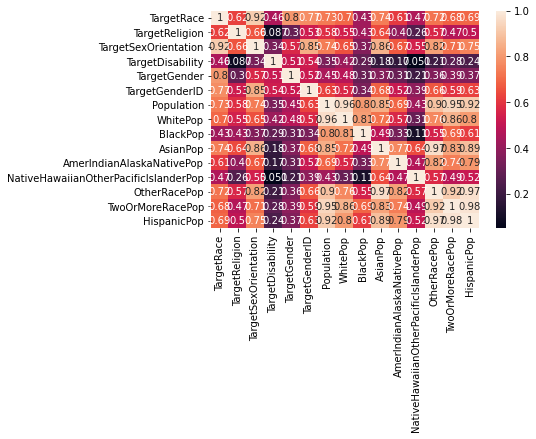

In [53]:
#Let's heatmap it
sns.heatmap(HC2019_USC2020_CM.corr(), annot=True)
#Not very legible but does give the idea

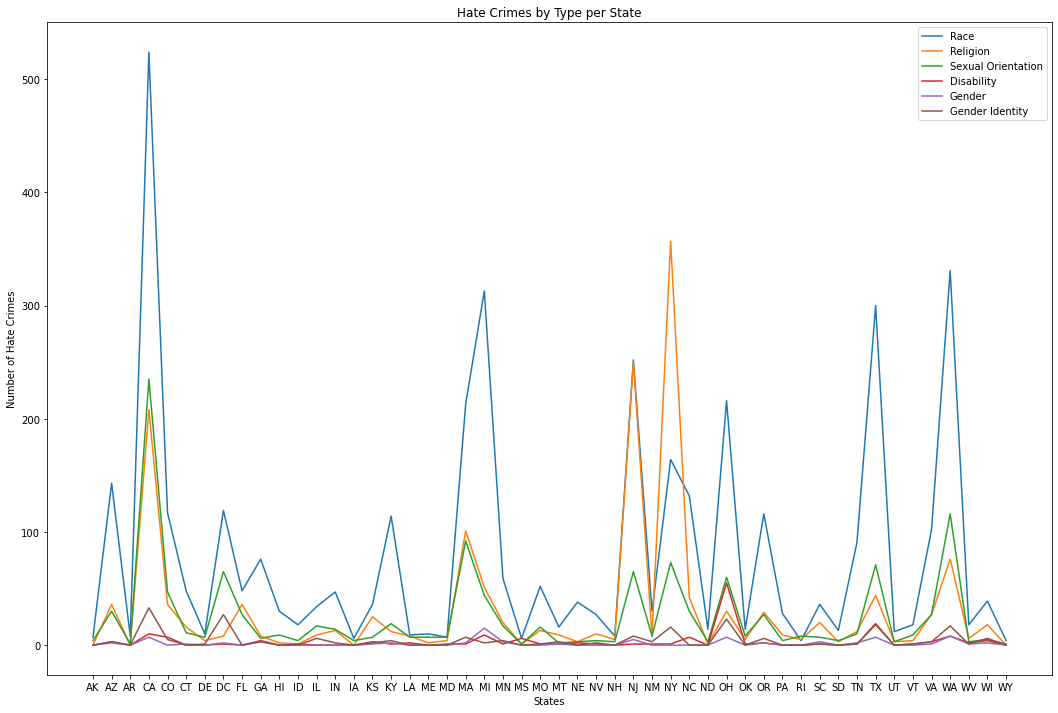

In [106]:
#Plotting for a visual
plt.figure(figsize=(18,12))
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetRace'], label='Race')
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetReligion'], label='Religion')
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetSexOrientation'], label='Sexual Orientation')
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetDisability'], label='Disability')
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetGender'], label='Gender')
plt.plot(HC2019_USC2020_NoPct['State'], HC2019_USC2020_NoPct['TargetGenderID'], label='Gender Identity')
plt.xlabel('States')
plt.ylabel('Number of Hate Crimes')
plt.title('Hate Crimes by Type per State')
plt.legend()
plt.show()

In [55]:
#Need to control for population
HC2019_USC2020_NoPct['RaceCrime100K'] = ((HC2019_USC2020_NoPct['TargetRace'] * 100000) / HC2019_USC2020_NoPct['Population']) 
HC2019_USC2020_NoPct['ReligionCrime100K'] = ((HC2019_USC2020_NoPct['TargetReligion'] * 100000) / HC2019_USC2020_NoPct['Population']) 
HC2019_USC2020_NoPct['SexOrientCrime100K'] = ((HC2019_USC2020_NoPct['TargetSexOrientation'] * 100000) / HC2019_USC2020_NoPct['Population']) 
HC2019_USC2020_NoPct['DisabilityCrime100K'] = ((HC2019_USC2020_NoPct['TargetDisability'] * 100000) / HC2019_USC2020_NoPct['Population']) 
HC2019_USC2020_NoPct['GenderCrime100K'] = ((HC2019_USC2020_NoPct['TargetGender'] * 100000) / HC2019_USC2020_NoPct['Population']) 
HC2019_USC2020_NoPct['GenderIDCrime100K'] = ((HC2019_USC2020_NoPct['TargetGenderID'] * 100000) / HC2019_USC2020_NoPct['Population']) 

<ipython-input-55-f12d01678b7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_NoPct['RaceCrime100K'] = ((HC2019_USC2020_NoPct['TargetRace'] * 100000) / HC2019_USC2020_NoPct['Population'])
<ipython-input-55-f12d01678b7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_NoPct['ReligionCrime100K'] = ((HC2019_USC2020_NoPct['TargetReligion'] * 100000) / HC2019_USC2020_NoPct['Population'])
<ipython-input-55-f12d01678b7e>:4: SettingWithCopyWarning: 
A value is trying to be set on a

In [56]:
HC2019_USC2020_NoPct.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population,WhitePop,BlackPop,...,NativeHawaiianOtherPacificIslanderPop,OtherRacePop,TwoOrMoreRacePop,HispanicPop,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K
0,AK,7,0,4,0,0,0,733391,435634,22002,...,12468,18335,89474,49871,0.954470,0.000000,0.545412,0.000000,0.000000,0.000000
1,AZ,143,36,30,3,2,3,7151502,4319507,336121,...,14303,901089,994059,2195511,1.999580,0.503391,0.419492,0.041949,0.027966,0.041949
2,AR,8,0,1,0,0,0,3011524,2114090,454740,...,15058,135519,213818,255980,0.265646,0.000000,0.033206,0.000000,0.000000,0.000000
3,CA,524,208,235,10,7,33,39538223,16289748,2253679,...,158153,8382103,5772581,15578060,1.325300,0.526073,0.594362,0.025292,0.017704,0.083464
4,CO,117,36,47,7,0,5,5773714,4082016,236722,...,11547,461897,710167,1264443,2.026425,0.623515,0.814034,0.121239,0.000000,0.086599


In [57]:
#Want subset of data so can just visualize crime controlled for population
HC2019_USC2020_Crime100K = HC2019_USC2020_NoPct[['State', 'RaceCrime100K', 'ReligionCrime100K', 'SexOrientCrime100K', 
                                                 'DisabilityCrime100K', 'GenderCrime100K', 'GenderIDCrime100K']]

In [58]:
HC2019_USC2020_Crime100K.head()

,State,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K
0,AK,0.954470,0.000000,0.545412,0.000000,0.000000,0.000000
1,AZ,1.999580,0.503391,0.419492,0.041949,0.027966,0.041949
2,AR,0.265646,0.000000,0.033206,0.000000,0.000000,0.000000
3,CA,1.325300,0.526073,0.594362,0.025292,0.017704,0.083464
4,CO,2.026425,0.623515,0.814034,0.121239,0.000000,0.086599


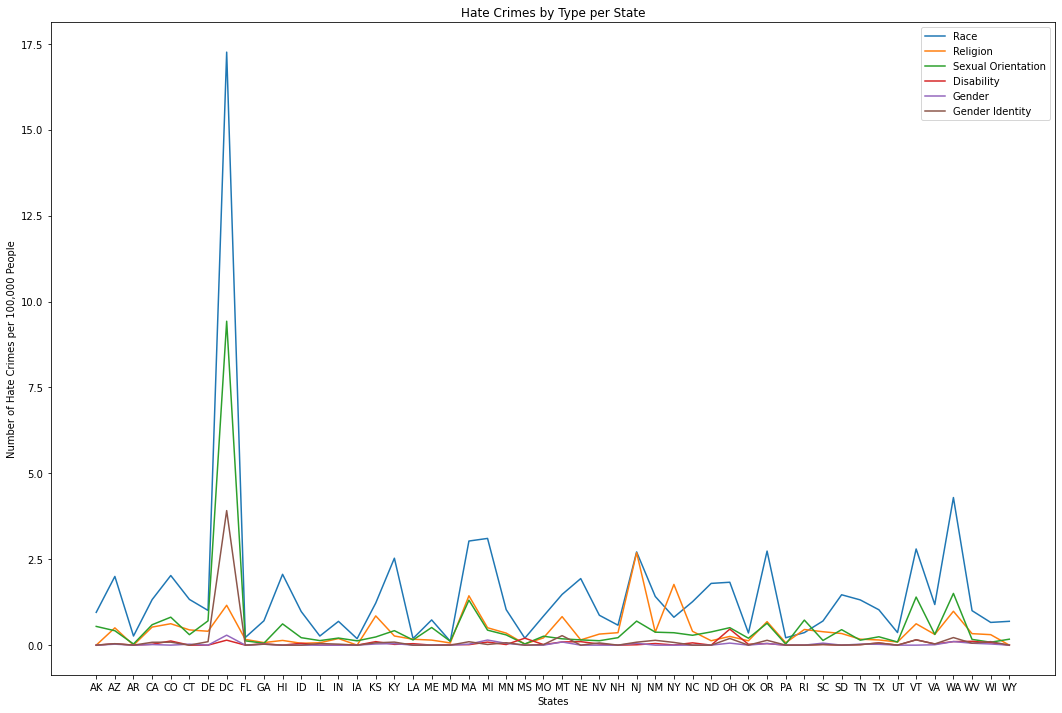

In [107]:
#Plotting for a visual
plt.figure(figsize=(18,12))
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['RaceCrime100K'], label='Race')
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['ReligionCrime100K'], label='Religion')
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['SexOrientCrime100K'], label='Sexual Orientation')
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['DisabilityCrime100K'], label='Disability')
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['GenderCrime100K'], label='Gender')
plt.plot(HC2019_USC2020_Crime100K['State'], HC2019_USC2020_Crime100K['GenderIDCrime100K'], label='Gender Identity')
plt.xlabel('States')
plt.ylabel('Number of Hate Crimes per 100,000 People')
plt.title('Hate Crimes by Type per State')
plt.legend()
plt.show()

In [ ]:
#Very different story the picture tells when you control for the population

In [60]:
#Want to visualize the demographic breakdown per state, so going to drop the crime data
HC2019_USC2020_NoCrime = HC2019_USC2020_NoPct[['State', 'Population', 'WhitePop', 'BlackPop', 'AsianPop',
                                   'AmerIndianAlaskaNativePop', 'NativeHawaiianOtherPacificIslanderPop', 'OtherRacePop',
                                   'TwoOrMoreRacePop', 'HispanicPop']]

In [177]:
HC2019_USC2020_NoCrime.head()

,State,Population,WhitePop,BlackPop,AsianPop,AmerIndianAlaskaNativePop,NativeHawaiianOtherPacificIslanderPop,OtherRacePop,TwoOrMoreRacePop,HispanicPop
0,AK,733391,435634,22002,44003,111475,12468,18335,89474,49871
1,AZ,7151502,4319507,336121,257454,321818,14303,901089,994059,2195511
2,AR,3011524,2114090,454740,51196,27104,15058,135519,213818,255980
3,CA,39538223,16289748,2253679,6088886,632612,158153,8382103,5772581,15578060
4,CO,5773714,4082016,236722,202080,75058,11547,461897,710167,1264443


In [61]:
#Need to control for population
HC2019_USC2020_NoCrime['WhitePop100K'] = ((HC2019_USC2020_NoCrime['WhitePop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['BlackPop100K'] = ((HC2019_USC2020_NoCrime['BlackPop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['AsianPop100K'] = ((HC2019_USC2020_NoCrime['AsianPop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['AmerIndianAlaskaNativePop100K'] = ((HC2019_USC2020_NoCrime['AmerIndianAlaskaNativePop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['NativeHawaiianOtherPacificIslanderPop100K'] = ((HC2019_USC2020_NoCrime['NativeHawaiianOtherPacificIslanderPop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['OtherRacePop100K'] = ((HC2019_USC2020_NoCrime['OtherRacePop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['TwoOrMoreRacePop100K'] = ((HC2019_USC2020_NoCrime['TwoOrMoreRacePop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 
HC2019_USC2020_NoCrime['HispanicPop100K'] = ((HC2019_USC2020_NoCrime['HispanicPop'] * 100000) / HC2019_USC2020_NoCrime['Population']) 

<ipython-input-61-12d7e1d73837>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_NoCrime['WhitePop100K'] = ((HC2019_USC2020_NoCrime['WhitePop'] * 100000) / HC2019_USC2020_NoCrime['Population'])
<ipython-input-61-12d7e1d73837>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_NoCrime['BlackPop100K'] = ((HC2019_USC2020_NoCrime['BlackPop'] * 100000) / HC2019_USC2020_NoCrime['Population'])
<ipython-input-61-12d7e1d73837>:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [62]:
HC2019_USC2020_NoCrime.head()

,State,Population,WhitePop,BlackPop,AsianPop,AmerIndianAlaskaNativePop,NativeHawaiianOtherPacificIslanderPop,OtherRacePop,TwoOrMoreRacePop,HispanicPop,WhitePop100K,BlackPop100K,AsianPop100K,AmerIndianAlaskaNativePop100K,NativeHawaiianOtherPacificIslanderPop100K,OtherRacePop100K,TwoOrMoreRacePop100K,HispanicPop100K
0,AK,733391,435634,22002,44003,111475,12468,18335,89474,49871,59399.965366,3000.036815,5999.937278,15199.941096,1700.048133,2500.030679,12200.040633,6800.056177
1,AZ,7151502,4319507,336121,257454,321818,14303,901089,994059,2195511,60399.997092,4700.005677,3599.998993,4500.005733,199.999944,12599.996476,13900.003104,30699.998406
2,AR,3011524,2114090,454740,51196,27104,15058,135519,213818,255980,70200.005047,15099.995882,1700.003055,900.009430,500.012618,4500.013946,7099.993226,8500.015275
3,CA,39538223,16289748,2253679,6088886,632612,158153,8382103,5772581,15578060,41200.000314,5700.000731,15399.999135,1600.001093,400.000273,21199.999302,14600.001118,39400.000349
4,CO,5773714,4082016,236722,202080,75058,11547,461897,710167,1264443,70700.003499,4099.995254,3500.000173,1299.995116,199.992587,7999.997922,12300.003083,21899.993661


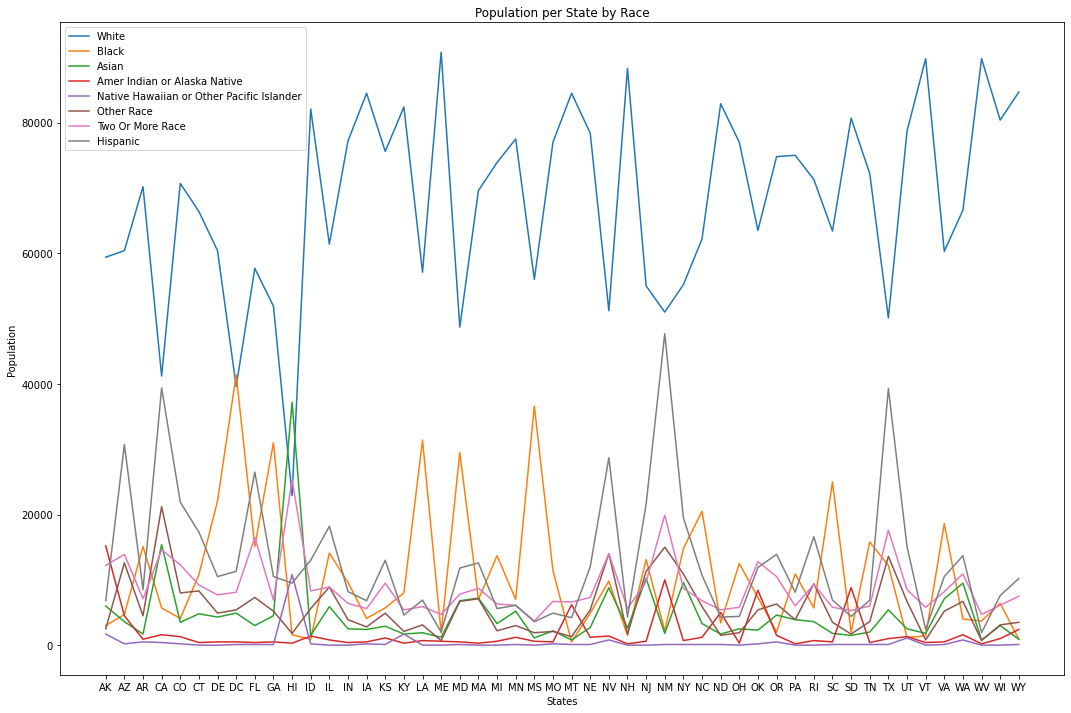

In [63]:
#Plot a visualization
plt.figure(figsize=(18,12))
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['WhitePop100K'], label='White')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['BlackPop100K'], label='Black')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['AsianPop100K'], label='Asian')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['AmerIndianAlaskaNativePop100K'], label='Amer Indian or Alaska Native')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['NativeHawaiianOtherPacificIslanderPop100K'], label='Native Hawaiian or Other Pacific Islander')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['OtherRacePop100K'], label='Other Race')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['TwoOrMoreRacePop100K'], label='Two Or More Race')
plt.plot(HC2019_USC2020_NoCrime['State'], HC2019_USC2020_NoCrime['HispanicPop100K'], label='Hispanic')
plt.xlabel('States')
plt.ylabel('Population')
plt.title('Population per State by Race')
plt.legend()
plt.show()

In [ ]:
#Not looking like we'll find an effect of the race demographics on type or number of hate crimes

In [164]:
#Data Analysis
#Q1 - Is there a difference in # of hate crimes among states with different Diversity Indices (DI)?
#IV is DI, continuous
#DV is number of crimes, continuous
#This suggests Simple Linear Regression
#Q2 - Is there a difference in types of hate crimes among states with different Diversity Indices (DI)?
#IV is DI, continuous
#DV is type of crimes, categorical and more than 2 levels
#This suggests (Stepwise) Multinomial Logistic Regression
#Now need dataset that contains DI, Total # Hate Crimes, and # of Hate Crime by Type

In [64]:
#Need total number of crimes rather than categories but controlled for population
HC2019_USC2020_NoPct['TotalCrime100K'] = (HC2019_USC2020_NoPct['RaceCrime100K'] + HC2019_USC2020_NoPct['ReligionCrime100K'] 
                                          + HC2019_USC2020_NoPct['SexOrientCrime100K'] + HC2019_USC2020_NoPct['DisabilityCrime100K']
                                          + HC2019_USC2020_NoPct['GenderCrime100K'] + HC2019_USC2020_NoPct['GenderIDCrime100K'])                                         

<ipython-input-64-cb617af919c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_NoPct['TotalCrime100K'] = (HC2019_USC2020_NoPct['RaceCrime100K'] + HC2019_USC2020_NoPct['ReligionCrime100K']


In [65]:
HC2019_USC2020_NoPct.head()

,State,TargetRace,TargetReligion,TargetSexOrientation,TargetDisability,TargetGender,TargetGenderID,Population,WhitePop,BlackPop,...,OtherRacePop,TwoOrMoreRacePop,HispanicPop,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K,TotalCrime100K
0,AK,7,0,4,0,0,0,733391,435634,22002,...,18335,89474,49871,0.954470,0.000000,0.545412,0.000000,0.000000,0.000000,1.499882
1,AZ,143,36,30,3,2,3,7151502,4319507,336121,...,901089,994059,2195511,1.999580,0.503391,0.419492,0.041949,0.027966,0.041949,3.034328
2,AR,8,0,1,0,0,0,3011524,2114090,454740,...,135519,213818,255980,0.265646,0.000000,0.033206,0.000000,0.000000,0.000000,0.298852
3,CA,524,208,235,10,7,33,39538223,16289748,2253679,...,8382103,5772581,15578060,1.325300,0.526073,0.594362,0.025292,0.017704,0.083464,2.572195
4,CO,117,36,47,7,0,5,5773714,4082016,236722,...,461897,710167,1264443,2.026425,0.623515,0.814034,0.121239,0.000000,0.086599,3.671813


In [68]:
#Need the population data for each race but controlled for variance in population between states 
HC2019_USC2020_TotalPop = HC2019_USC2020_NoCrime[['State', 'Population', 'WhitePop100K', 'BlackPop100K', 'AsianPop100K',
                                   'AmerIndianAlaskaNativePop100K', 'NativeHawaiianOtherPacificIslanderPop100K', 
                                                  'OtherRacePop100K', 'TwoOrMoreRacePop100K', 'HispanicPop100K']]

In [69]:
HC2019_USC2020_TotalPop.head()

,State,Population,WhitePop100K,BlackPop100K,AsianPop100K,AmerIndianAlaskaNativePop100K,NativeHawaiianOtherPacificIslanderPop100K,OtherRacePop100K,TwoOrMoreRacePop100K,HispanicPop100K
0,AK,733391,59399.965366,3000.036815,5999.937278,15199.941096,1700.048133,2500.030679,12200.040633,6800.056177
1,AZ,7151502,60399.997092,4700.005677,3599.998993,4500.005733,199.999944,12599.996476,13900.003104,30699.998406
2,AR,3011524,70200.005047,15099.995882,1700.003055,900.009430,500.012618,4500.013946,7099.993226,8500.015275
3,CA,39538223,41200.000314,5700.000731,15399.999135,1600.001093,400.000273,21199.999302,14600.001118,39400.000349
4,CO,5773714,70700.003499,4099.995254,3500.000173,1299.995116,199.992587,7999.997922,12300.003083,21899.993661


In [71]:
#Now need to calculate DI for each state. Start by finding N, the total number of individuals in community
HC2019_USC2020_TotalPop['N'] = (HC2019_USC2020_TotalPop['WhitePop100K'] + HC2019_USC2020_TotalPop['BlackPop100K'] 
                                + HC2019_USC2020_TotalPop['AsianPop100K'] + HC2019_USC2020_TotalPop['AmerIndianAlaskaNativePop100K'] 
                                + HC2019_USC2020_TotalPop['NativeHawaiianOtherPacificIslanderPop100K']
                               + HC2019_USC2020_TotalPop['OtherRacePop100K'] + HC2019_USC2020_TotalPop['TwoOrMoreRacePop100K'] 
                                + HC2019_USC2020_TotalPop['HispanicPop100K'])

<ipython-input-71-80d947735f28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_TotalPop['N'] = (HC2019_USC2020_TotalPop['WhitePop100K'] + HC2019_USC2020_TotalPop['BlackPop100K']


In [72]:
HC2019_USC2020_TotalPop.head()

,State,Population,WhitePop100K,BlackPop100K,AsianPop100K,AmerIndianAlaskaNativePop100K,NativeHawaiianOtherPacificIslanderPop100K,OtherRacePop100K,TwoOrMoreRacePop100K,HispanicPop100K,N
0,AK,733391,59399.965366,3000.036815,5999.937278,15199.941096,1700.048133,2500.030679,12200.040633,6800.056177,106800.056177
1,AZ,7151502,60399.997092,4700.005677,3599.998993,4500.005733,199.999944,12599.996476,13900.003104,30699.998406,130600.005425
2,AR,3011524,70200.005047,15099.995882,1700.003055,900.009430,500.012618,4500.013946,7099.993226,8500.015275,108500.048480
3,CA,39538223,41200.000314,5700.000731,15399.999135,1600.001093,400.000273,21199.999302,14600.001118,39400.000349,139500.002314
4,CO,5773714,70700.003499,4099.995254,3500.000173,1299.995116,199.992587,7999.997922,12300.003083,21899.993661,121999.981295


In [73]:
#Now calculate ni(ni-1) for each race and sum for state
HC2019_USC2020_TotalPop['ni_Sum'] = (HC2019_USC2020_TotalPop['WhitePop100K'] * (HC2019_USC2020_TotalPop['WhitePop100K']-1) 
                                 + HC2019_USC2020_TotalPop['BlackPop100K'] * (HC2019_USC2020_TotalPop['BlackPop100K']-1)
                                + HC2019_USC2020_TotalPop['AsianPop100K'] * (HC2019_USC2020_TotalPop['AsianPop100K']-1) 
                                     + HC2019_USC2020_TotalPop['AmerIndianAlaskaNativePop100K'] * (HC2019_USC2020_TotalPop['AmerIndianAlaskaNativePop100K']-1) 
                                + HC2019_USC2020_TotalPop['NativeHawaiianOtherPacificIslanderPop100K'] * (HC2019_USC2020_TotalPop['NativeHawaiianOtherPacificIslanderPop100K']-1)
                               + HC2019_USC2020_TotalPop['OtherRacePop100K']  * (HC2019_USC2020_TotalPop['OtherRacePop100K']-1)
                                     + HC2019_USC2020_TotalPop['TwoOrMoreRacePop100K'] * (HC2019_USC2020_TotalPop['TwoOrMoreRacePop100K']-1) 
                                + HC2019_USC2020_TotalPop['HispanicPop100K'] * (HC2019_USC2020_TotalPop['HispanicPop100K']-1))

<ipython-input-73-d840bdcf19a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_TotalPop['ni_Sum'] = (HC2019_USC2020_TotalPop['WhitePop100K'] * (HC2019_USC2020_TotalPop['WhitePop100K']-1)


In [75]:
#Now calculate D
HC2019_USC2020_TotalPop['D'] = (HC2019_USC2020_TotalPop['ni_Sum'] / ((HC2019_USC2020_TotalPop['N']) * (HC2019_USC2020_TotalPop['N'] - 1)))

<ipython-input-75-4d973b8ba231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_TotalPop['D'] = (HC2019_USC2020_TotalPop['ni_Sum'] / ((HC2019_USC2020_TotalPop['N']) * (HC2019_USC2020_TotalPop['N'] - 1)))


In [77]:
#Now calculate 1 - D
HC2019_USC2020_TotalPop['DI'] = (1 - HC2019_USC2020_TotalPop['D'])

<ipython-input-77-927ad4c1da06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HC2019_USC2020_TotalPop['DI'] = (1 - HC2019_USC2020_TotalPop['D'])


In [78]:
HC2019_USC2020_TotalPop.head()

,State,Population,WhitePop100K,BlackPop100K,AsianPop100K,AmerIndianAlaskaNativePop100K,NativeHawaiianOtherPacificIslanderPop100K,OtherRacePop100K,TwoOrMoreRacePop100K,HispanicPop100K,N,ni_Sum,D,DI
0,AK,733391,59399.965366,3000.036815,5999.937278,15199.941096,1700.048133,2500.030679,12200.040633,6800.056177,106800.056177,4.008509e+09,0.351434,0.648566
1,AZ,7151502,60399.997092,4700.005677,3599.998993,4500.005733,199.999944,12599.996476,13900.003104,30699.998406,130600.005425,4.997829e+09,0.293021,0.706979
2,AR,3011524,70200.005047,15099.995882,1700.003055,900.009430,500.012618,4500.013946,7099.993226,8500.015275,108500.048480,5.302802e+09,0.450453,0.549547
3,CA,39538223,41200.000314,5700.000731,15399.999135,1600.001093,400.000273,21199.999302,14600.001118,39400.000349,139500.002314,4.184631e+09,0.215036,0.784964
4,CO,5773714,70700.003499,4099.995254,3500.000173,1299.995116,199.992587,7999.997922,12300.003083,21899.993661,121999.981295,5.724058e+09,0.384581,0.615419


In [79]:
HC2019_USC2020_DI = HC2019_USC2020_TotalPop[['State', 'DI']]

In [80]:
HC2019_USC2020_DI.head()

,State,DI
0,AK,0.648566
1,AZ,0.706979
2,AR,0.549547
3,CA,0.784964
4,CO,0.615419


In [83]:
HC2019_USC2020_TypeCrime = HC2019_USC2020_NoPct[['State', 'RaceCrime100K', 'ReligionCrime100K', 'SexOrientCrime100K',
                                                'DisabilityCrime100K', 'GenderCrime100K', 'GenderIDCrime100K', 'TotalCrime100K']]

In [84]:
HC2019_USC2020_TypeCrime.head()

,State,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K,TotalCrime100K
0,AK,0.954470,0.000000,0.545412,0.000000,0.000000,0.000000,1.499882
1,AZ,1.999580,0.503391,0.419492,0.041949,0.027966,0.041949,3.034328
2,AR,0.265646,0.000000,0.033206,0.000000,0.000000,0.000000,0.298852
3,CA,1.325300,0.526073,0.594362,0.025292,0.017704,0.083464,2.572195
4,CO,2.026425,0.623515,0.814034,0.121239,0.000000,0.086599,3.671813


In [85]:
#Can now merge tables based on State column
HC2019_USC2020_CrimeDI = pd.merge(HC2019_USC2020_DI, HC2019_USC2020_TypeCrime)

In [86]:
HC2019_USC2020_CrimeDI.head()

,State,DI,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K,TotalCrime100K
0,AK,0.648566,0.954470,0.000000,0.545412,0.000000,0.000000,0.000000,1.499882
1,AZ,0.706979,1.999580,0.503391,0.419492,0.041949,0.027966,0.041949,3.034328
2,AR,0.549547,0.265646,0.000000,0.033206,0.000000,0.000000,0.000000,0.298852
3,CA,0.784964,1.325300,0.526073,0.594362,0.025292,0.017704,0.083464,2.572195
4,CO,0.615419,2.026425,0.623515,0.814034,0.121239,0.000000,0.086599,3.671813


In [88]:
#Simple Linear Regression 

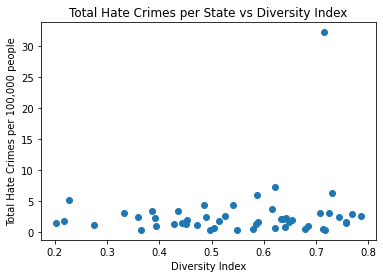

In [91]:
#Visualize to see if relationship is indeed linear
plt.scatter(HC2019_USC2020_CrimeDI.DI, HC2019_USC2020_CrimeDI.TotalCrime100K)
plt.title('Total Hate Crimes per State vs Diversity Index')
plt.xlabel('Diversity Index')
plt.ylabel('Total Hate Crimes per 100,000 people')
plt.show()
#Appears mostly linear

<AxesSubplot:>

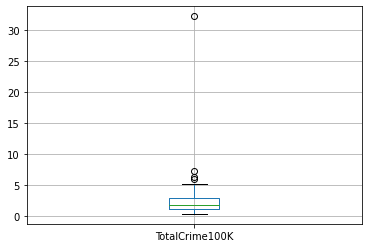

In [90]:
HC2019_USC2020_CrimeDI.boxplot(column='TotalCrime100K')
#some outliers

In [100]:
#Need p value
import statsmodels.api as sm
y = HC2019_USC2020_CrimeDI['TotalCrime100K']
x = HC2019_USC2020_CrimeDI[['DI']]
model = sm.OLS(y, x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:         TotalCrime100K   R-squared (uncentered):                   0.287
Model:                            OLS   Adj. R-squared (uncentered):              0.273
Method:                 Least Squares   F-statistic:                              19.76
Date:                Thu, 14 Apr 2022   Prob (F-statistic):                    5.03e-05
Time:                        05:10:41   Log-Likelihood:                         -145.46
No. Observations:                  50   AIC:                                      292.9
Df Residuals:                      49   BIC:                                      294.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#p value is less than 0.05 - there is a statistically significant association between DI and TotalCrime
#R-squared is 0.287 so only 28% of variation in Total Crime can be explained by DI

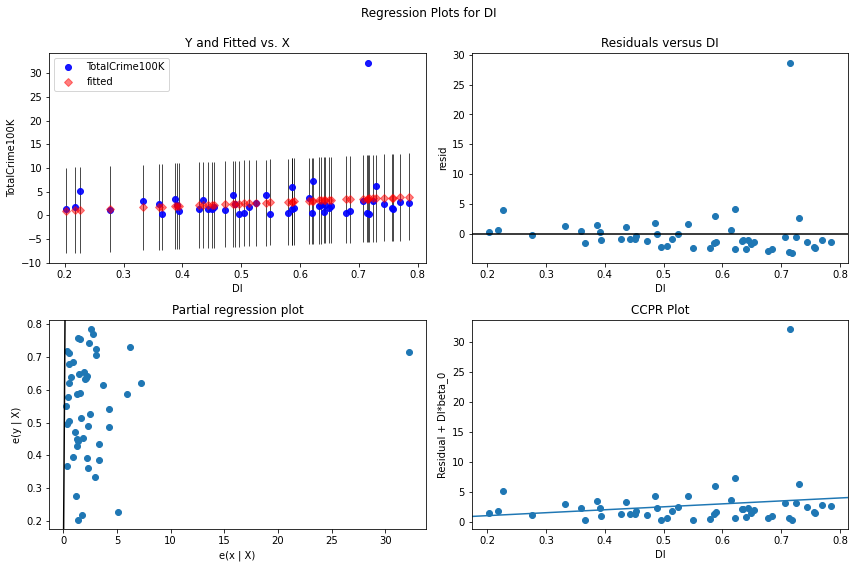

In [101]:
#it appears homoscedasticity is not violated (as per 1st graph - residual vs fitted values plot)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'DI', fig=fig)

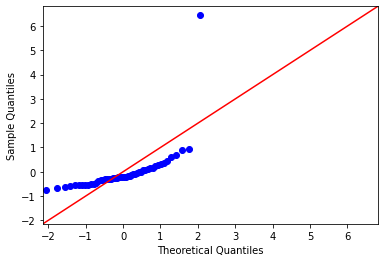

In [93]:
res = model.resid
fig = sm.qqplot(res, fit=True, line="45")
plt.show()
#Not quite normal distribution but tending towards positive correlation, so higher DI associated with higher Total Hate Crimes

In [104]:
#Now create Correlation Matrix for dataset
HC2019_USC2020_CrimeDI.corr(method='pearson')

,DI,RaceCrime100K,ReligionCrime100K,SexOrientCrime100K,DisabilityCrime100K,GenderCrime100K,GenderIDCrime100K,TotalCrime100K
DI,1.000000,0.130651,0.220304,0.150321,-0.139773,0.042087,0.146253,0.153955
RaceCrime100K,0.130651,1.000000,0.392890,0.969174,0.266278,0.854109,0.944453,0.992620
ReligionCrime100K,0.220304,0.392890,1.000000,0.333036,0.049736,0.383899,0.268510,0.454911
SexOrientCrime100K,0.150321,0.969174,0.333036,1.000000,0.214090,0.781383,0.975887,0.980635
DisabilityCrime100K,-0.139773,0.266278,0.049736,0.214090,1.000000,0.341666,0.234441,0.260569
GenderCrime100K,0.042087,0.854109,0.383899,0.781383,0.341666,1.000000,0.803423,0.844030
GenderIDCrime100K,0.146253,0.944453,0.268510,0.975887,0.234441,0.803423,1.000000,0.956798
TotalCrime100K,0.153955,0.992620,0.454911,0.980635,0.260569,0.844030,0.956798,1.000000


<AxesSubplot:>

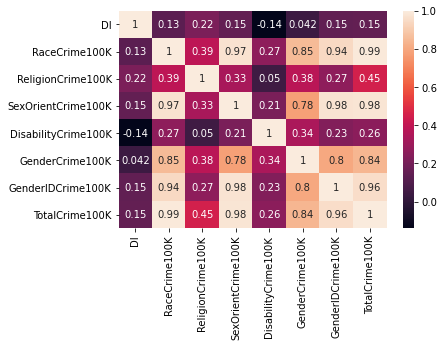

In [105]:
#Let's heatmap it
sns.heatmap(HC2019_USC2020_CrimeDI.corr(), annot=True)
#Shows low correlation between DI and Total Hate Crimes. Low correlation between DI and any type of crime.
#Negative correlation between DI and Disability Crime.